# OncoRTT methods.

### This notebook provides an implementation of the OncoRTT tool to predict therapeutic target genes for ten cancer types.
Each cancer has its own model and FVs. The code here read the generated embeddings for amino-acid sequences using ProtTrans-BERT embeddings.
Several preprocessing and preparation steps have been implemented before utilizing this code for each cancer type. For example:
- A demo for how we generate BERT embeddings is provided for thyroid cancer *(see OncoRTT_ProtTransBert model- ThyroidCancer-demo.py)*
- All genes were read from three sources: positive targets, cancer genes, and negative genes, which are combined, shuffled and then used to generate the embeddings using their amino-acid sequences. These combined genes are saved in the Combined_Genes folder.

In [6]:
!git clone https://github.com/imchiragcr7/OncoRTT.git

Cloning into 'OncoRTT'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 119 (delta 6), reused 27 (delta 4), pack-reused 89
Receiving objects: 100% (119/119), 71.85 MiB | 19.45 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Updating files: 100% (106/106), done.


In [8]:
# all needed packages
import pandas as pd
import math as math
import numpy as np
import json, csv, itertools
from matplotlib import pyplot

# Machine learninig packages
from sklearn import linear_model, ensemble, metrics
from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold
from sklearn.metrics import *
!pip install xgboost
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
!pip install tensorflow
# DL Keras
!pip install keras
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.layers import Input, Reshape, Dense, Concatenate, Dropout
from keras.models import Sequential, Model

import tensorflow as tf

In [23]:
#Define 10 cancer types
cancertypes = ["Bladder","Breast", "Colon", "Kidney", "Liver","Luk",
               "Lung", "NonHodgkinLymph", "Rectal", "Thyroid" ]

## OncoRTT-DL OMICS-based FV

In [24]:
## Define the DL Model
DL_model = Sequential()
DL_model.add(Dense(64, input_dim=5, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# DL_model.add(Dropout(0.2))
DL_model.add(Dense(32,  activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
DL_model.add(Dense(1, activation='sigmoid'))

## Define 10-fold CV
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 10)

In [31]:
DL_omCancerAUC = []
DL_omCancerFPR= []
DL_omCancerTPR= []

for cancer in cancertypes:
    print('\n*Working with '+ cancer + " Cancer*" )

    ## Read  combined genes (positive and negative genes) per Cancer
    Genes = pd.read_csv('/content/OncoRTT/Data/OncologyTT Datasets/combined_Genes/'+str(cancer)+'_Genes.csv')

    ## Read generated BERT embeddings for each genes
    Embed = np.genfromtxt('/content/OncoRTT/BERT_EMBED/'+str(cancer)+'_Embed.txt')
    Embed_df = pd.DataFrame(Embed)
    # /content/OncoRTT/Data/Baseline_method_Datasets/BERT_EMBED_baseline/BladderEmbed.txt

    ## The embeddings have the same order of the combined genes,
    #  so concat them using the index
    allG_em = pd.merge(Genes, Embed_df,right_index=True,left_index=True)

    ## Read gene mutation and gene expression
    GE = pd.read_csv('/content/OncoRTT/Data/Baseline_method_Datasets/OMICS_baseline_features/'+str(cancer)+'_gene_exp2.csv')
    Mu = pd.read_csv("/content/OncoRTT/Data/Baseline_method_Datasets/OMICS_baseline_features/"+str(cancer)+"_gene_mut2.csv")
    # merge OMICS features and remove the samples GE values
    OMICS = pd.merge(GE, Mu, on=['Gene'], how='inner')
    CncerOM = OMICS[["Gene","MAX","AVG","MED","MIN","COUNT"]]

    # integrate all festures and get the lable, remove all genes with no label
    CancerFV = pd.merge(allG_em, CncerOM, on=['Gene'], how='outer')
    CancerFV = CancerFV[CancerFV['Label'].notna()]
    CancerFV = CancerFV.fillna(0)

    # The FV is only the omics features for omics models
    X = np.array(CancerFV[["MAX","AVG","MED","MIN","COUNT"]])
    Y = np.array(CancerFV['Label'],dtype=int)

    print('Features and Label shapes', X.shape, Y.shape)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    # all evaluation lists
    auc = []
    fpr = []
    tpr = []

    # Compile model
    DL_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

    foldCounter = 1
    # Start training and testing
    for train_index, test_index in  skf.split(X,Y):

        print("*** Working with Fold %i :***" %foldCounter)
        #Apply normalization using MaxAbsolute normlization
        min_max_scaler = MinMaxScaler()
        X_train = min_max_scaler.fit(X[train_index])
        X_train_transform = min_max_scaler.transform(X[train_index])
        X_test_transform = min_max_scaler.transform(X[test_index])

        DL_model.fit(X_train_transform, Y[train_index], epochs=20,
                 batch_size=16)
        predictedScore = DL_model.predict(X_test_transform)
        #  our model's predictions.
        predictedClass= np.argmax(predictedScore, axis=0)

        #print("@@ Validation and evaluation of fold %i @@" %foldCounter)
        fr, tr, _ = roc_curve(Y[test_index], predictedScore)
        fpr.append(fr)
        tpr.append(tr)
        #print("AUC =  %f" %roc_auc_score(Y[test_index], predictedScore))
        auc.append(roc_auc_score(Y[test_index], predictedScore))

        print('------------------------------------------------------')
        foldCounter += 1

    #----------------------------------------------------------
    Fpr = np.array(sorted(list(itertools.chain.from_iterable(fpr))))
    Tpr = np.array(sorted(list(itertools.chain.from_iterable(tpr))))
    #-------------------------------------------------
    ### Print Evaluation Metrics.......................
    print("Results using test data: AUC = " + str( np.array(auc).mean().round(decimals=4) ))
    DL_aucROC = np.array(auc).mean().round(decimals=4)
    DL_omCancerAUC.append(np.array(DL_aucROC).mean())
    DL_omCancerFPR.append(Fpr)
    DL_omCancerTPR.append(Tpr)


*Working with Bladder Cancer*
Features and Label shapes (239, 5) (239,)
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
*** Working with Fold 1 :***
Epoch 1/20
14/14 [==============================] - 2s 5ms/step - loss: 0.6961 - accuracy: 0.4977
Epoch 2/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6895 - accuracy: 0.4837
Epoch 3/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.5163
Epoch 4/20
14/14 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5209
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5209
Epoch 6/20
14/14 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.4791
Epoch 7/20
14/14 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.4651
Epoch 8/20
14/14 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5209
Epoch 9/20
14/14 [==============================] - 0s 5

IndexError: list index out of range

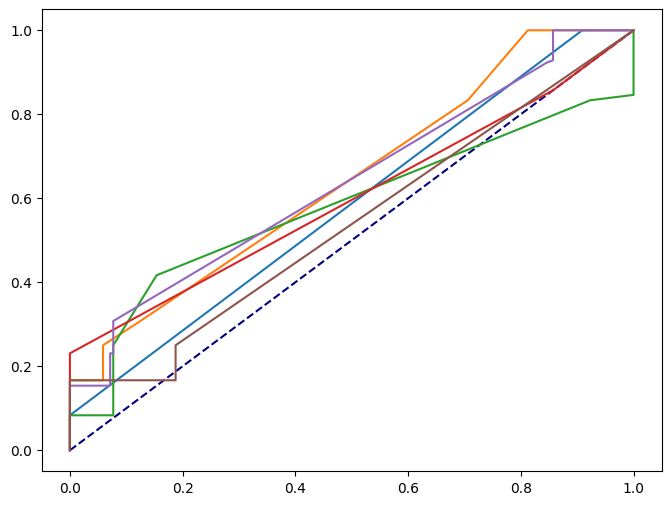

In [34]:
# plot the roc curve for the omics models
pyplot.figure(figsize=[8, 6])
# pyplot.grid(b=None, which='major',axis='both',linestyle=':')
pyplot.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='dashed')
pyplot.plot(DL_omCancerFPR[0], DL_omCancerTPR[0],label='Bladder: auc = %0.2f' % np.array(DL_omCancerAUC[0]).mean())
pyplot.plot(DL_omCancerFPR[1], DL_omCancerTPR[1],label='Breast: auc = %0.2f' % np.array(DL_omCancerAUC[1]).mean())
pyplot.plot(DL_omCancerFPR[2], DL_omCancerTPR[2],label='Colon: auc = %0.2f' % np.array(DL_omCancerAUC[2]).mean())
pyplot.plot(DL_omCancerFPR[3], DL_omCancerTPR[3],label='Kidney: auc = %0.2f' % np.array(DL_omCancerAUC[3]).mean())
pyplot.plot(DL_omCancerFPR[4], DL_omCancerTPR[4],label='Liver: auc = %0.2f' % np.array(DL_omCancerAUC[4]).mean())
pyplot.plot(DL_omCancerFPR[5], DL_omCancerTPR[5],label='Leukemia: auc = %0.2f' % np.array(DL_omCancerAUC[5]).mean())
pyplot.plot(DL_omCancerFPR[6], DL_omCancerTPR[6],label='Lung: auc = %0.2f' % np.array(DL_omCancerAUC[6]).mean())
pyplot.plot(DL_omCancerFPR[7], DL_omCancerTPR[7],label='Non-Hodgkin’s lymphoma: auc = %0.2f' % np.array(DL_omCancerAUC[7]).mean())
pyplot.plot(DL_omCancerFPR[8], DL_omCancerTPR[8],label='Rectal: auc = %0.2f' % np.array(DL_omCancerAUC[8]).mean())
pyplot.plot(DL_omCancerFPR[9], DL_omCancerTPR[9],label='Thyroid: auc = %0.2f' % np.array(DL_omCancerAUC[9]).mean())

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('OMICS-based FV -DNN Classifier')

# show the legend
pyplot.legend(loc='best',fontsize = 9,shadow=True)
# pyplot.savefig('Figures/OMICS_FV_DNN_10Cancers.jpeg')
# show the plot
pyplot.show()

## OncoRTT-DL Embeddings-based FV

In [ ]:
## Define the DL Model
input_dim = 1024
DL_model = Sequential()
DL_model.add(Dense(64, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
# DL_model.add(Dropout(0.2))
DL_model.add(Dense(32,  activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
DL_model.add(Dense(1, activation='sigmoid'))

In [ ]:
cancertypes = ["Bladder","Breast", "Colon", "Kidney", "Liver","Luk",
               "Lung", "NonHodgkinLymph", "Rectal", "Thyroid" ]

DL_emCancerAUC = []
DL_emCancerFPR= []
DL_emCancerTPR= []

for cancer in cancertypes:
    print('\n*Working with '+ cancer + " Cancer*" )

    ## Read  combined genes (positive and negative genes) per Cancer
    Genes = pd.read_csv('Datasets/combinedGenes_cancer/'+str(cancer)+'_Genes.csv')

    ## Read generated BERT embeddings for each genes
    Embed = np.genfromtxt('BERT_Embed/'+str(cancer)+'_Embed.txt')
    Embed_df = pd.DataFrame(Embed)

    ## The embeddings have the same order of the combined genes,
    #  so concat them using the index
    allG_em = pd.merge(Genes, Embed_df,right_index=True,left_index=True)

    ## Read gene mutation and gene expression
    GE = pd.read_csv('Datasets/OMICS/'+str(cancer)+'_gene_exp.csv')
    Mu = pd.read_csv('Datasets/OMICS/'+str(cancer)+'_gene_mut.csv')
    OMICS = pd.merge(GE, Mu, on=['Gene'], how='inner')
    CncerOM = OMICS[["Gene","MAX","AVG","MED","MIN","COUNT"]]

    CancerFV = pd.merge(allG_em, CncerOM, on=['Gene'], how='outer')
    CancerFV = CancerFV[CancerFV['Label'].notna()]
    CancerFV = CancerFV.fillna(0)

    FV = CancerFV.drop(["Gene", "Sequence","Label","MAX","AVG","MED","MIN","COUNT"], axis=1)
    X = np.array(FV)
    Y = np.array(CancerFV['Label'],dtype=int)

    print('Features and Label shapes', X.shape, Y.shape)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

    # all evaluation lists
    auc = []
    fpr = []
    tpr = []

    # Compile model
    DL_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

    foldCounter = 1
    # Start training and testing
    for train_index, test_index in  skf.split(X,Y):

        print("*** Working with Fold %i :***" %foldCounter)
        #Apply normalization using MaxAbsolute normlization
        max_abs_scaler = MinMaxScaler()
        X_train = max_abs_scaler.fit(X[train_index])
        X_train_transform = max_abs_scaler.transform(X[train_index])
        X_test_transform = max_abs_scaler.transform(X[test_index])

        DL_model.fit(X_train_transform, Y[train_index], epochs=20,
                 batch_size=16)
        predictedScore = DL_model.predict(X_test_transform)
        #  our model's predictions.
        predictedClass= np.argmax(predictedScore, axis=0)

        #print("@@ Validation and evaluation of fold %i @@" %foldCounter)
        fr, tr, _ = roc_curve(Y[test_index], predictedScore)
        fpr.append(fr)
        tpr.append(tr)
        #print("AUC =  %f" %roc_auc_score(Y[test_index], predictedScore))
        auc.append(roc_auc_score(Y[test_index], predictedScore))

        print('------------------------------------------------------')
        foldCounter += 1

    #----------------------------------------------------------
    Fpr = np.array(sorted(list(itertools.chain.from_iterable(fpr))))
    Tpr = np.array(sorted(list(itertools.chain.from_iterable(tpr))))
    #-------------------------------------------------
    ### Print Evaluation Metrics.......................
    print("Results:AUC = " + str( np.array(auc).mean().round(decimals=4) ))

    DL_aucROC = np.array(auc).mean().round(decimals=4)
    DL_emCancerAUC.append(np.array(DL_aucROC).mean())
    DL_emCancerFPR.append(Fpr)
    DL_emCancerTPR.append(Tpr)

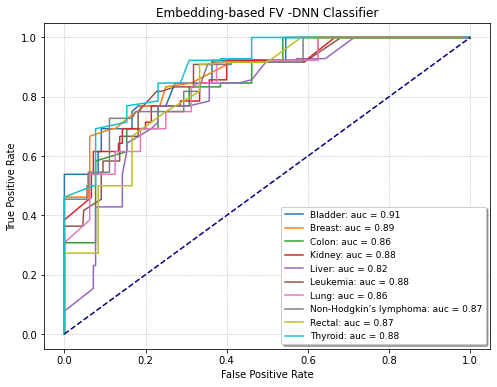

In [ ]:
# plot the roc curve for the model
pyplot.figure(figsize=[8, 6])
pyplot.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='dashed')
pyplot.grid(b=None, which='major', axis='both',linestyle=':')
pyplot.plot(DL_emCancerFPR[0], DL_emCancerTPR[0],label='Bladder: auc = %0.2f' % np.array(DL_emCancerAUC[0]).mean())
pyplot.plot(DL_emCancerFPR[1], DL_emCancerTPR[1],label='Breast: auc = %0.2f' % np.array(DL_emCancerAUC[1]).mean())
pyplot.plot(DL_emCancerFPR[2], DL_emCancerTPR[2],label='Colon: auc = %0.2f' % np.array(DL_emCancerAUC[2]).mean())
pyplot.plot(DL_emCancerFPR[3], DL_emCancerTPR[3],label='Kidney: auc = %0.2f' % np.array(DL_emCancerAUC[3]).mean())
pyplot.plot(DL_emCancerFPR[4], DL_emCancerTPR[4],label='Liver: auc = %0.2f' % np.array(DL_emCancerAUC[4]).mean())
pyplot.plot(DL_emCancerFPR[5], DL_emCancerTPR[5],label='Leukemia: auc = %0.2f' % np.array(DL_emCancerAUC[5]).mean())
pyplot.plot(DL_emCancerFPR[6], DL_emCancerTPR[6],label='Lung: auc = %0.2f' % np.array(DL_emCancerAUC[6]).mean())
pyplot.plot(DL_emCancerFPR[7], DL_emCancerTPR[7],label='Non-Hodgkin’s lymphoma: auc = %0.2f' % np.array(DL_emCancerAUC[7]).mean())
pyplot.plot(DL_emCancerFPR[8], DL_emCancerTPR[8],label='Rectal: auc = %0.2f' % np.array(DL_emCancerAUC[8]).mean())
pyplot.plot(DL_emCancerFPR[9], DL_emCancerTPR[9],label='Thyroid: auc = %0.2f' % np.array(DL_emCancerAUC[9]).mean())

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('Embedding-based FV -DNN Classifier')

# show the legend
pyplot.legend(loc='best',fontsize = 9,shadow=True)
# pyplot.legend(bbox_to_anchor=(1.05, 1.0, 0.1, 0.1), loc='best',fontsize = 9)
pyplot.savefig('Figures/Embeddings_FV_DNN_10Cancers.jpeg')
# show the plot
pyplot.show()

## OncoRTT-DL Integrated-based FV (OMICS+Embeddings)

In [ ]:
## OncoRTT-DL OMICS-based FV
## Define the Classifiers
input_dim = 1029
DL_model = Sequential()
DL_model.add(Dense(64, input_dim=input_dim, kernel_initializer='normal', activation='tanh'))
# DL_model.add(Dropout(0.2))
DL_model.add(Dense(32,  activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
DL_model.add(Dense(1, activation='sigmoid'))

In [ ]:
DL_CancerAUC = []
DL_CancerFPR= []
DL_CancerTPR= []

for cancer in cancertypes:
    print('\n*Working with '+ cancer + " Cancer*" )

    ## Read  combined genes (positive and negative genes) per Cancer
    Genes = pd.read_csv('Datasets/combinedGenes_cancer/'+str(cancer)+'_Genes.csv')

    ## Read generated BERT embeddings for each genes
    Embed = np.genfromtxt('BERT_Embed/'+str(cancer)+'_Embed.txt')
    Embed_df = pd.DataFrame(Embed)

    ## The embeddings have the same order of the combined genes,
    #  so concat them using the index
    allG_em = pd.merge(Genes, Embed_df,right_index=True,left_index=True)

    ## Read gene mutation and gene expression
    GE = pd.read_csv('Datasets/OMICS/'+str(cancer)+'_gene_exp.csv')
    Mu = pd.read_csv('Datasets/OMICS/'+str(cancer)+'_gene_mut.csv')

    OMICS = pd.merge(GE, Mu, on=['Gene'], how='inner')
    CncerOM = OMICS[["Gene","MAX","AVG","MED","MIN","COUNT"]]

    CancerFV = pd.merge(allG_em, CncerOM, on=['Gene'], how='outer')
    CancerFV = CancerFV[CancerFV['Label'].notna()]
    CancerFV = CancerFV.fillna(0)

    FV = CancerFV.drop(["Gene", "Sequence","Label"], axis=1)
    X = np.array(FV)
    Y = np.array(CancerFV['Label'],dtype=int)

    print('Features and Label shapes', X.shape, Y.shape)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

    # all evaluation lists
    auc = []
    fpr = []
    tpr = []

    # Compile model
    DL_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

    foldCounter = 1
    # Start training and testing
    for train_index, test_index in  skf.split(X,Y):

        print("*** Working with Fold %i :***" %foldCounter)
        #Apply normalization using MaxAbsolute normlization
        max_abs_scaler = MinMaxScaler()
        X_train = max_abs_scaler.fit(X[train_index])
        X_train_transform = max_abs_scaler.transform(X[train_index])
        X_test_transform = max_abs_scaler.transform(X[test_index])

        DL_model.fit(X_train_transform, Y[train_index], epochs=20,
                 batch_size=16)
        predictedScore = DL_model.predict(X_test_transform)
        #  our model's predictions.
        predictedClass= np.argmax(predictedScore, axis=0)

        #print("@@ Validation and evaluation of fold %i @@" %foldCounter)
        fr, tr, _ = roc_curve(Y[test_index], predictedScore)
        fpr.append(fr)
        tpr.append(tr)
        #print("AUC =  %f" %roc_auc_score(Y[test_index], predictedScore))
        auc.append(roc_auc_score(Y[test_index], predictedScore))

        print('------------------------------------------------------')
        foldCounter += 1

    #----------------------------------------------------------
    Fpr = np.array(sorted(list(itertools.chain.from_iterable(fpr))))
    Tpr = np.array(sorted(list(itertools.chain.from_iterable(tpr))))
    #-------------------------------------------------
    ### Print Evaluation Metrics.......................
    print("Results:AUC = " + str( np.array(auc).mean().round(decimals=4) ))

    DL_aucROC = np.array(auc).mean().round(decimals=4)
    DL_CancerAUC.append(np.array(DL_aucROC).mean())
    DL_CancerFPR.append(Fpr)
    DL_CancerTPR.append(Tpr)

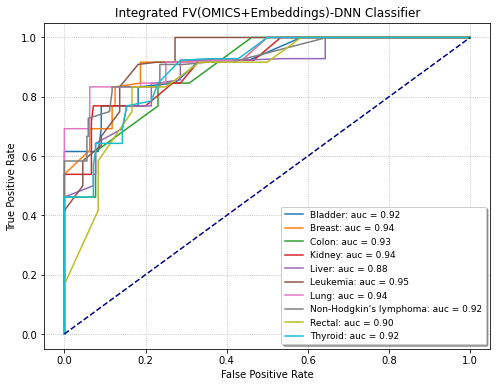

In [ ]:
# plot the roc curve for the integrated FV models
pyplot.figure(figsize=[8, 6])

pyplot.plot(DL_CancerFPR[0], DL_CancerTPR[0],label='Bladder: auc = %0.2f' % np.array(DL_CancerAUC[0]).mean())
pyplot.plot(DL_CancerFPR[1], DL_CancerTPR[1],label='Breast: auc = %0.2f' % np.array(DL_CancerAUC[1]).mean())
pyplot.plot(DL_CancerFPR[2], DL_CancerTPR[2],label='Colon: auc = %0.2f' % np.array(DL_CancerAUC[2]).mean())
pyplot.plot(DL_CancerFPR[3], DL_CancerTPR[3],label='Kidney: auc = %0.2f' % np.array(DL_CancerAUC[3]).mean())
pyplot.plot(DL_CancerFPR[4], DL_CancerTPR[4],label='Liver: auc = %0.2f' % np.array(DL_CancerAUC[4]).mean())
pyplot.plot(DL_CancerFPR[5], DL_CancerTPR[5],label='Leukemia: auc = %0.2f' % np.array(DL_CancerAUC[5]).mean())
pyplot.plot(DL_CancerFPR[6], DL_CancerTPR[6],label='Lung: auc = %0.2f' % np.array(DL_CancerAUC[6]).mean())
pyplot.plot(DL_CancerFPR[7], DL_CancerTPR[7],label='Non-Hodgkin’s lymphoma: auc = %0.2f' % np.array(DL_CancerAUC[7]).mean())
pyplot.plot(DL_CancerFPR[8], DL_CancerTPR[8],label='Rectal: auc = %0.2f' % np.array(DL_CancerAUC[8]).mean())
pyplot.plot(DL_CancerFPR[9], DL_CancerTPR[9],label='Thyroid: auc = %0.2f' % np.array(DL_CancerAUC[9]).mean())
pyplot.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='dashed')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('Integrated FV(OMICS+Embeddings)-DNN Classifier')
pyplot.grid(b=None, which='major', axis='both',linestyle=':')

# show the legend
pyplot.legend(loc='best',fontsize = 9,shadow=True)
# pyplot.savefig('Figures/Integrated_FV_DNN_10Cancers.jpeg')
# show the plot
pyplot.show()

In [ ]:
## END of the Code